In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../../")

In [2]:
from methods import lc_extrapolation, pfn
from tasks import toy_priors
import numpy as np
import pandas as pd
import torch

import json
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba
from decimal import Decimal
%matplotlib inline

In [3]:
with open("../data/lcbench_val_data.npy", "rb") as f:
    X = np.load(f).reshape(-1, 50)

In [40]:
def get_data():
    return pd.read_csv("../data/lcbench_results.csv")

In [41]:
df = get_data()

In [42]:
df

,t,y_pred,y,model,config_id,cutoff,nsamples,ll,fit_time,predict_time
0,11,0.813617,0.810329,lc_extrapolation,45,10,520,2.349772,85.594260,9.824594
1,12,0.815466,0.740412,lc_extrapolation,45,10,520,0.520382,85.594260,9.824594
2,13,0.817066,0.788350,lc_extrapolation,45,10,520,1.950928,85.594260,9.824594
3,14,0.818468,0.795496,lc_extrapolation,45,10,520,2.096184,85.594260,9.824594
4,15,0.819709,0.827153,lc_extrapolation,45,10,520,2.244968,85.594260,9.824594
...,...,...,...,...,...,...,...,...,...,...
262495,46,0.453957,0.454820,pfn1000,349,40,2500,3.962094,0.000067,0.007926
262496,47,0.454000,0.454820,pfn1000,349,40,2500,3.960086,0.000067,0.007926
262497,48,0.454041,0.455829,pfn1000,349,40,2500,3.921077,0.000067,0.007926
262498,49,0.454081,0.456061,pfn1000,349,40,2500,3.920455,0.000067,0.007926


<AxesSubplot:xlabel='cutoff', ylabel='ll'>

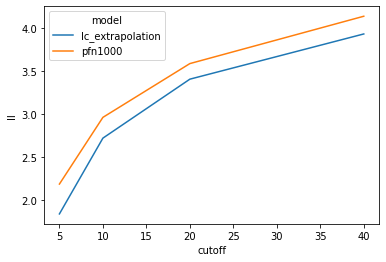

In [43]:
fig, ax = plt.subplots()

sns.lineplot(data=df.groupby(["model", "cutoff"])["ll"].mean().reset_index(), 
             x="cutoff", y="ll", hue="model", ax=ax)

In [44]:
df

,t,y_pred,y,model,config_id,cutoff,nsamples,ll,fit_time,predict_time
0,11,0.813617,0.810329,lc_extrapolation,45,10,520,2.349772,85.594260,9.824594
1,12,0.815466,0.740412,lc_extrapolation,45,10,520,0.520382,85.594260,9.824594
2,13,0.817066,0.788350,lc_extrapolation,45,10,520,1.950928,85.594260,9.824594
3,14,0.818468,0.795496,lc_extrapolation,45,10,520,2.096184,85.594260,9.824594
4,15,0.819709,0.827153,lc_extrapolation,45,10,520,2.244968,85.594260,9.824594
...,...,...,...,...,...,...,...,...,...,...
262495,46,0.453957,0.454820,pfn1000,349,40,2500,3.962094,0.000067,0.007926
262496,47,0.454000,0.454820,pfn1000,349,40,2500,3.960086,0.000067,0.007926
262497,48,0.454041,0.455829,pfn1000,349,40,2500,3.921077,0.000067,0.007926
262498,49,0.454081,0.456061,pfn1000,349,40,2500,3.920455,0.000067,0.007926


In [101]:
df.drop(["t", "nsamples"], axis=1) # , "fit_time", "predict_time", "ll"
df["inference_time"] = df["fit_time"] + df["predict_time"]

In [117]:
df_g = df.groupby(["model", "cutoff", "config_id"])

MSE = df_g[["y_pred", "y"]].apply(lambda x: ((x.y_pred - x.y).values**2).mean()).reset_index().reset_index().groupby(["model", "cutoff"])[0]

TIME = df_g[["inference_time"]].first().reset_index().groupby(["model", "cutoff"])[["inference_time"]]
LL = df_g["ll"].mean().reset_index().groupby(["model", "cutoff"])["ll"]
for model in ["lc_extrapolation", "pfn1000"]:
    res_cutoff = " & ".join(["{:.2e} $\\pm$ {:.2f} & {:.2} $\\pm$ {:.2}  & {:.2} $\\pm$ {:.2}".format(
            MSE.mean().loc[model, cutoff], 
                                                                                MSE.std().loc[model, cutoff],
                                                                                LL.mean().loc[model, cutoff], 
                                                                                LL.std().loc[model, cutoff],
    TIME.mean().loc[model, 40].inference_time, 
        TIME.std().loc[model, 40].inference_time,) 
 for cutoff in [5, 10, 20 ,40]])
    print("{:17} & {} \\\\".format(
        model,
        res_cutoff
    ))

lc_extrapolation  & 2.18e-03 $\pm$ 0.01 & 1.8 $\pm$ 0.69  & 1e+02 $\pm$ 3.2e+01 & 2.95e-04 $\pm$ 0.00 & 2.7 $\pm$ 0.62  & 1e+02 $\pm$ 3.2e+01 & 8.01e-05 $\pm$ 0.00 & 3.4 $\pm$ 0.7  & 1e+02 $\pm$ 3.2e+01 & 1.88e-05 $\pm$ 0.00 & 3.9 $\pm$ 0.65  & 1e+02 $\pm$ 3.2e+01 \\
pfn1000           & 1.26e-03 $\pm$ 0.00 & 2.2 $\pm$ 0.59  & 0.0091 $\pm$ 0.00073 & 2.52e-04 $\pm$ 0.00 & 3.0 $\pm$ 0.6  & 0.0091 $\pm$ 0.00073 & 5.24e-05 $\pm$ 0.00 & 3.6 $\pm$ 0.69  & 0.0091 $\pm$ 0.00073 & 1.19e-04 $\pm$ 0.00 & 4.1 $\pm$ 0.41  & 0.0091 $\pm$ 0.00073 \\
